# Principal Component Analysis 

## An Example Of A Factor Model

## Step By Step
1. Pull the S&P 600 Index data.
2. Implement a momentum trading strategy.
3. Performance analysis.

Import packages

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import pickle
import matplotlib.pyplot as plt

Set parameters

In [2]:
# Lookback period
lookback = 250

# Number of factors or principal components
number_of_factors = 5

# Top n stocks
top_n = 50

## 1. Pull The S&P 600 Index Data
Recall that historical data of the S&P 600 SmallCap Index has already been collected in a previous article.

Load data

In [3]:
with open('sp600_data.pickle', 'rb') as f:
    data = pickle.load(f)
    
f.close()

Close prices

In [4]:
close = data.close.loc['2014-06-11':]

Fill NaNs with the previous value

In [5]:
close.fillna(method='ffill', inplace=True)

Calculate daily returns

In [6]:
returns = close.pct_change()

## 2. Implement A Momentum Trading Strategy
Apply the Principal Component Analysis (PCA) to identify factors.
Deploy the Ordinary Least Squares (OLS) to explain stock returns with factors
Use the factors as signals in a momentum trading strategy, i.e. buy(sell) the top(bottom) contributors.

Initialize positions

In [7]:
positions = pd.DataFrame({},
                        index=returns.index,
                        columns=returns.columns)

# Set to 0s
positions.fillna(0, inplace=True)

Routine

In [8]:
for i in range(lookback + 1, len(close)):
    
    # Calculate the daily returns
    R = returns.iloc[i - lookback + 1:i, :]
    
    # Avoid daily returns which contain NaN
    has_data = (R.count() == max(R.count()))
    has_data_list = list(R.columns[has_data])
    R = R.loc[:, has_data_list]
    
    # Calculate the mean of daily returns
    R_mean = R.mean()
    
    # Calculate the adjusted daily returns
    R_adj = R.sub(R_mean)
    
    # Calculate the covariance matrix
    cov = R_adj.cov()
    
    # Calculate the eigenvalues(B) and eigenvectors(X)
    eigen = np.linalg.eig(cov)
    B = eigen[0]
    X = eigen[1]
    
    # Retain only a number of factors
    X = X[:, :number_of_factors]
    
    # OLS
    model = sm.OLS(R_adj.iloc[-1], X)
    results = model.fit()
    b = results.params
    
    # Calculate the expected returns
    R_exp = R_mean.add(np.matmul(X, b))
    
    # Momentum trading strategy
    # Short positions
    shorts = R_exp.sort_values()[:top_n].index
    positions.iloc[i][shorts] = -1
    # Long positions
    longs = R_exp.sort_values()[-top_n:].index
    positions.iloc[i][longs] = 1

## 3. Performance Analysis 

Adjust the positions

In [9]:
# Shift since we use close prices
positions = positions.shift(periods=1)

Compute the daily returns of the momentum trading strategy

In [10]:
returns_strat = (positions.mul(returns)).sum(axis='columns')

Compute the annualized average return of the momentum trading strategy

In [11]:
returns_strat_avg = returns_strat.mean() * 250

In [12]:
returns_strat_avg

-2.0378186524235113

Plot the cumulative PnL

Text(0.5, 1.0, 'Cumulative PnL of Momentum Trading Strategy')

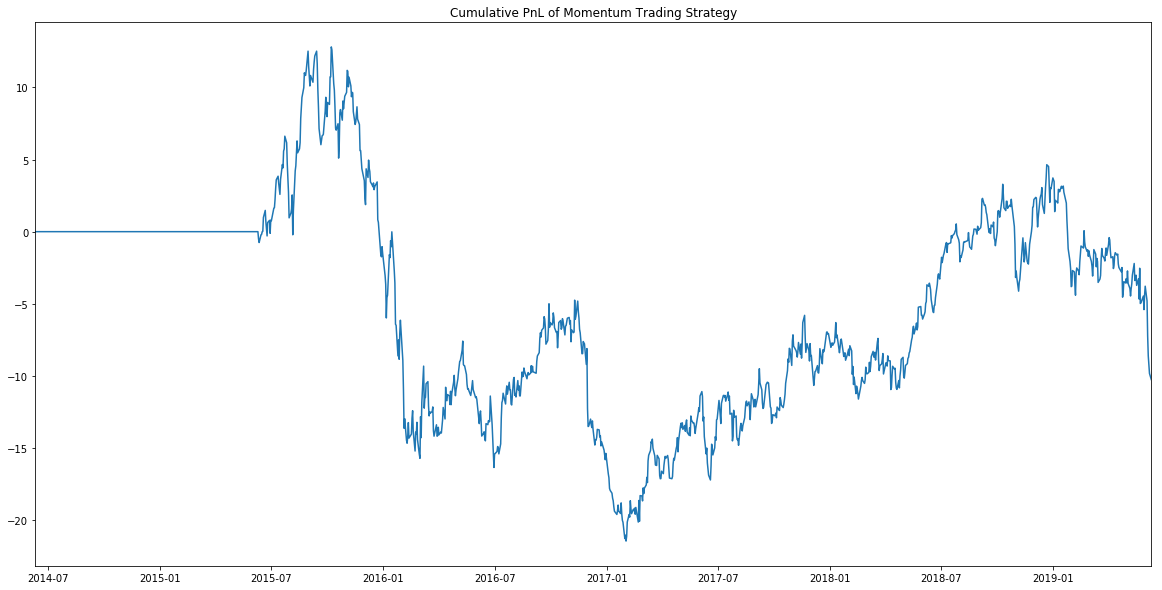

In [13]:
plt.figure(figsize=(20, 10))

plt.plot(returns_strat.cumsum())
plt.xlim(returns_strat.index[0], returns_strat.index[-1])

plt.title('Cumulative PnL of Momentum Trading Strategy')